In [1]:
from scipy import io
import os
import os.path as osp
from scipy import sparse
import dgl
import torch
import pandas as pd

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Loading Graphs:

- N: directed heterogeneous graph in homogeneous form: post+user by post+user

N has following composition:

- U: directed homogeneous graph: user by user (user replies user)
- PU: directed heterogeneous graph: post by user (post written by author)
- UP: directed heterogeneous graph: user by post (first level user reply post & author writes post)

In [2]:
fp = '/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data'

In [3]:
graph = io.loadmat(osp.join(fp, 'interim', 'graph', 'graph.mat'))

In [21]:
graph

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed May 13 17:05:19 2020',
 '__version__': '1.0',
 '__globals__': [],
 'N': <596681x596681 sparse matrix of type '<class 'numpy.float64'>'
 	with 1844634 stored elements in Compressed Sparse Column format>,
 'N_edge': array([[     0,      0,      1, ..., 596678, 596678, 596680],
        [ 82368, 588698,    780, ...,  65107,  65110, 433243]], dtype=int32),
 'N_edge_weight': array([[1.42294746],
        [1.42294746],
        [1.42294746],
        ...,
        [1.42294746],
        [1.63886708],
        [1.42294746]]),
 'U': <479723x479723 sparse matrix of type '<class 'numpy.float64'>'
 	with 1610712 stored elements in Compressed Sparse Column format>,
 'U_edge': array([[     0,      0,      1, ..., 479718, 479719, 479722],
        [ 64112, 471740,    780, ...,  86670, 104585, 316285]], dtype=int32),
 'U_edge_weight': array([[1.42294746],
        [1.42294746],
        [1.42294746],
        ...,
        [1.42294746],
      

In [22]:
N, U, PU, UP = graph['N'], graph['U'], graph['PU'], graph['UP']
N_edge_weight = graph['N_edge_weight']
U_edge_weight = graph['U_edge_weight']
PU_edge_weight = graph['PU_edge_weight']
UP_edge_weight = graph['UP_edge_weight']
P_label = graph['P_label']

# N Graph

## general graph EDA

In [5]:
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(N)
g.edata['weight'] = torch.from_numpy(N_edge_weight)

### number of nodes and number of edges

In [6]:
print(g)

DGLGraph(num_nodes=596681, num_edges=1844634,
         ndata_schemes={}
         edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})


In [7]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 3.0914910982585333 edges per node


### Node Statistics

in degree stats

In [8]:
indegree = g.in_degrees(g.nodes()).numpy()

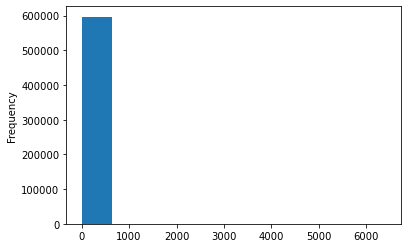

In [9]:
pd.Series(indegree).plot(kind = 'hist')

In [10]:
pd.Series(indegree).describe()

count    596681.000000
mean          3.091491
std          22.275691
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max        6416.000000
dtype: float64

omitt outliers

In [11]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).describe()

count    591536.000000
mean          1.998957
std           4.681746
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          47.000000
dtype: float64

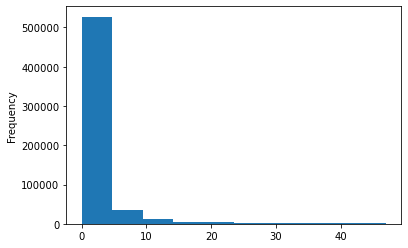

In [12]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).plot(kind = 'hist')

most of in nodes have indegree 1 between 2 and 10

In [13]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree > 2)]).describe()

count    72325.000000
mean         4.909907
std          1.859802
min          3.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          9.000000
dtype: float64

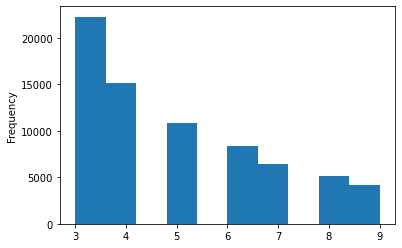

In [14]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree > 2)]).plot(kind = 'hist')

out degree stats

In [15]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [16]:
pd.Series(outdegree).describe()

count    596681.000000
mean          3.091491
std          48.376868
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       30768.000000
dtype: float64

omitt outliers

In [17]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).describe()

count    595672.000000
mean          2.706678
std           5.963406
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          99.000000
dtype: float64

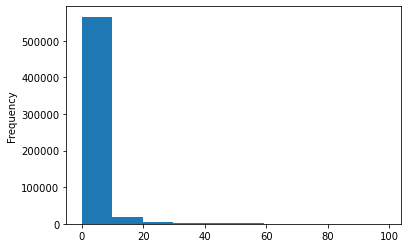

In [18]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).plot(kind='hist')

indegree between two and ten

In [19]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree > 2)]).describe()

count    96517.000000
mean         4.634572
std          1.777630
min          3.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          9.000000
dtype: float64

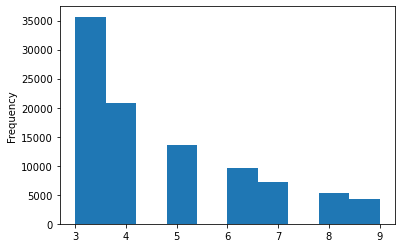

In [20]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree > 2)]).plot(kind='hist')

The in degree and out degree have the same distribution, and the graph is very sparse.

# U Graph


In [26]:
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(U)
g.edata['weight'] = torch.from_numpy(U_edge_weight)

## number of nodes and number of edges

In [27]:
print(g)

DGLGraph(num_nodes=479723, num_edges=1610712,
         ndata_schemes={}
         edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})


In [28]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 3.357587607848696 edges per node


## Node Statistics
### In degree analysis

In [29]:
indegree = g.in_degrees(g.nodes()).numpy()

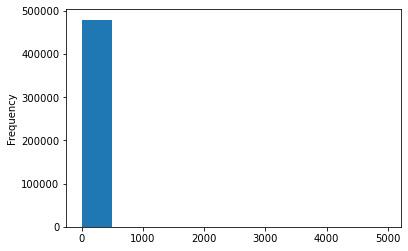

In [30]:
pd.Series(indegree).plot(kind = 'hist')

In [32]:
pd.Series(indegree).describe()

count    479723.000000
mean          3.357588
std          22.802664
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        4968.000000
dtype: float64

In [38]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).describe()

count    475103.000000
mean          2.122757
std           5.092450
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          48.000000
dtype: float64

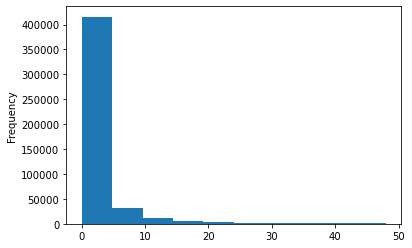

In [39]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).plot(kind = 'hist')

In [44]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree >= 0)]).value_counts(normalize = True)

0    0.582496
1    0.184501
2    0.081677
3    0.047461
4    0.031856
5    0.022753
6    0.017044
7    0.013151
8    0.010561
9    0.008500
dtype: float64

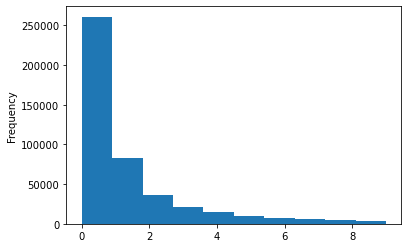

In [45]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree >= 0)]).plot(kind = 'hist')

In [46]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [49]:
pd.Series(outdegree).describe()

count    479723.000000
mean          3.357588
std          51.976645
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       29320.000000
dtype: float64

In [50]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).describe()

count    478942.000000
mean          2.951529
std           6.647182
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         107.000000
dtype: float64

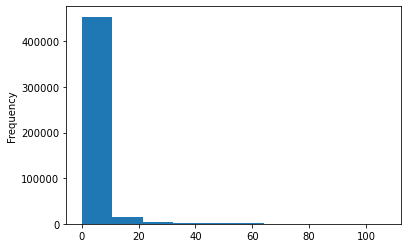

In [51]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).plot(kind='hist')

In [55]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree >= 0)]).value_counts(normalize = True)

1    0.488563
0    0.160454
2    0.151207
3    0.073185
4    0.043320
5    0.028403
6    0.019990
7    0.014804
8    0.011144
9    0.008930
dtype: float64

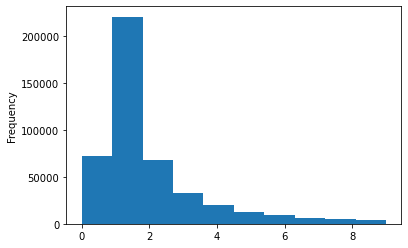

In [54]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree >= 0)]).plot(kind = 'hist')

# PU Graph

In [56]:
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(PU)
g.edata['weight'] = torch.from_numpy(PU_edge_weight)

In [57]:
print(g)

DGLGraph(num_nodes=479723, num_edges=116963,
         ndata_schemes={}
         edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})


In [58]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 0.243813617441732 edges per node


In [59]:
indegree = g.in_degrees(g.nodes()).numpy()

In [61]:
pd.Series(indegree).describe()

count    479723.000000
mean          0.243814
std           3.247989
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1448.000000
dtype: float64

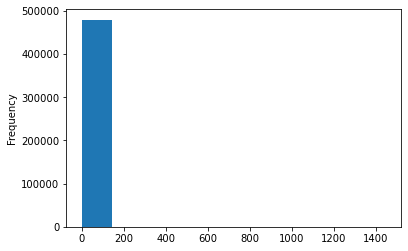

In [60]:
pd.Series(indegree).plot(kind = 'hist')

In [62]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).describe()

count    478003.000000
mean          0.177886
std           0.554717
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
dtype: float64

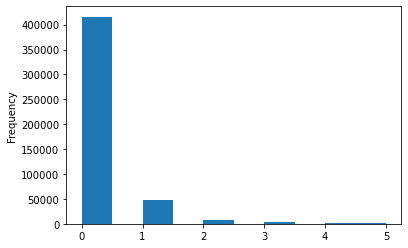

In [63]:
pd.Series(indegree[(indegree < (6)) & \
                   (indegree >= 0)]).plot(kind = 'hist')

In [64]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [65]:
pd.Series(outdegree).describe()

count    479723.000000
mean          0.243814
std           0.429435
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
dtype: float64

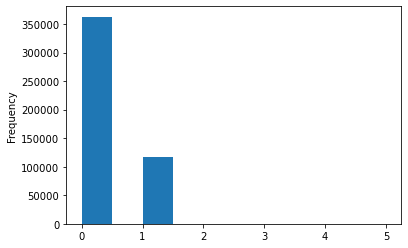

In [67]:
pd.Series(outdegree).plot(kind = 'hist')

# UP Graph

In [68]:
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(UP)
g.edata['weight'] = torch.from_numpy(UP_edge_weight)

In [69]:
print(g)

DGLGraph(num_nodes=479723, num_edges=116959,
         ndata_schemes={}
         edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})


In [70]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 0.24380527929659407 edges per node


In [71]:
indegree = g.in_degrees(g.nodes()).numpy()

In [72]:
pd.Series(indegree).describe()

count    479723.000000
mean          0.243805
std           0.429382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
dtype: float64

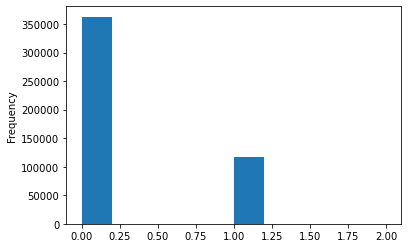

In [73]:
pd.Series(indegree).plot(kind = 'hist')

In [74]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [75]:
pd.Series(outdegree).describe()

count    479723.000000
mean          0.243805
std           3.247923
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1448.000000
dtype: float64

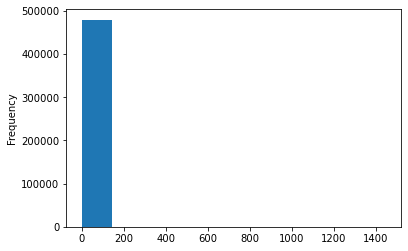

In [76]:
pd.Series(outdegree).plot(kind = 'hist')

In [77]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).describe()

count    478003.000000
mean          0.177880
std           0.554706
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
dtype: float64

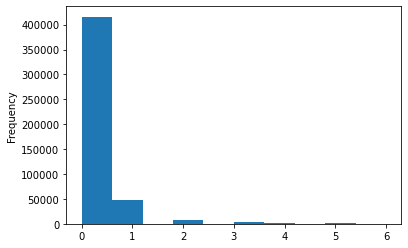

In [78]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).plot(kind = 'hist')